In [135]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()  
])
#Transforms from Geeks for Geeks 

Load Data and basic insights

In [136]:
data_dir = "cnn_part_1_dataset"
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print(f"Total samples loaded: {len(full_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class labels: {full_dataset.classes[:]}")

Total samples loaded: 100800
Number of classes: 36
Class labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Samples count

In [137]:
from collections import Counter

labels = [sample[1] for sample in full_dataset]
label_counts = Counter(labels)

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
counts_named = {idx_to_class[i]: count for i, count in label_counts.items()}
#Geeks for Geeks

/var/folders/1x/b2ps0syd5979tshhjzmjmftc0000gn/T/ipykernel_92207/1575711638.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_named.keys()), y=list(counts_named.values()), palette="viridis")


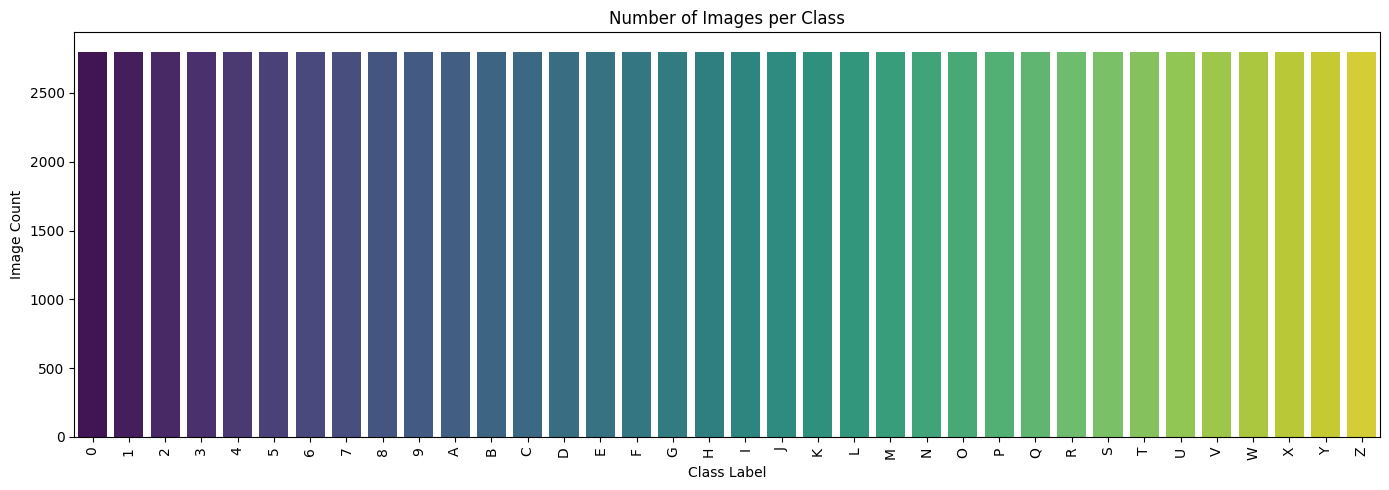

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
sns.barplot(x=list(counts_named.keys()), y=list(counts_named.values()), palette="viridis")
plt.title("Number of Images per Class")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

It shows perfect class balance.

Sample Images

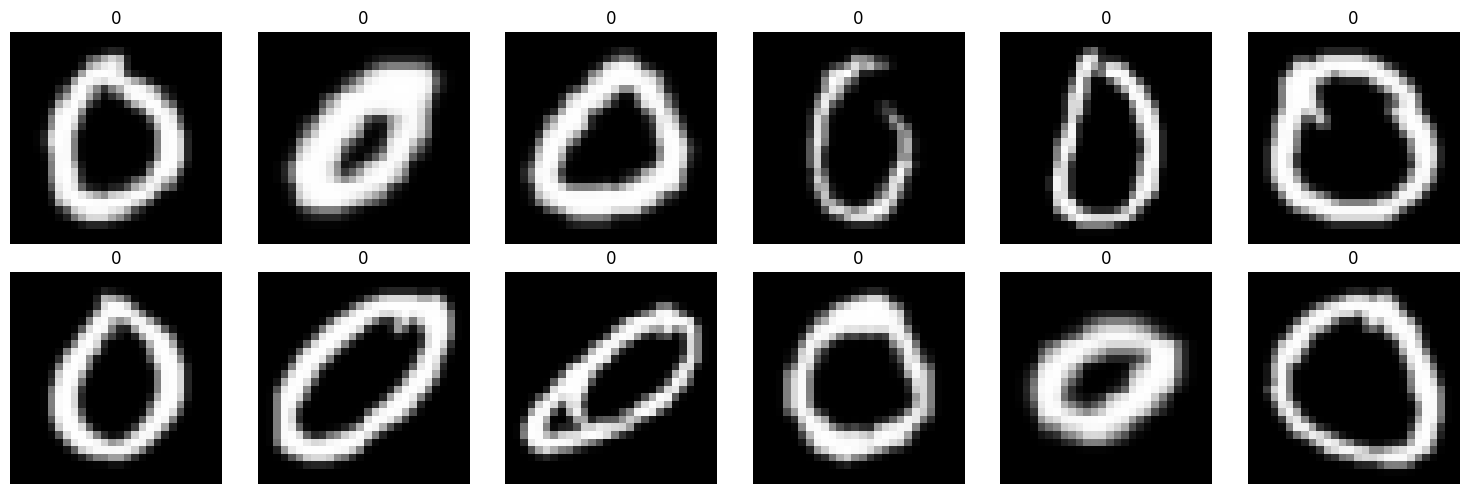

In [139]:
def show_image_grid(dataset, samples_per_row=6):
    fig, axes = plt.subplots(2, samples_per_row, figsize=(15, 5))
    for i in range(2 * samples_per_row):
        img, label = dataset[i * 100]
        img_np = img.permute(1, 2, 0).numpy()
        ax = axes[i // samples_per_row, i % samples_per_row]
        ax.imshow(img_np)
        ax.set_title(full_dataset.classes[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid(full_dataset)


Pixel Value Distribution

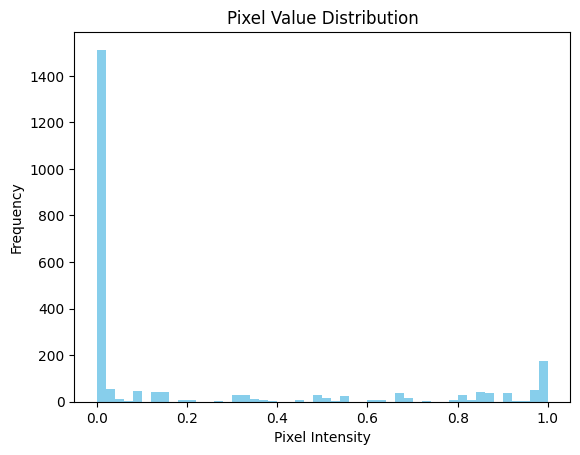

In [140]:
sample_img, _ = full_dataset[0]
plt.hist(sample_img.numpy().flatten(), bins=50, color='skyblue')
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


It showed a strong peak near 0 (black background) and near 1 (white foreground).

Average Image per class

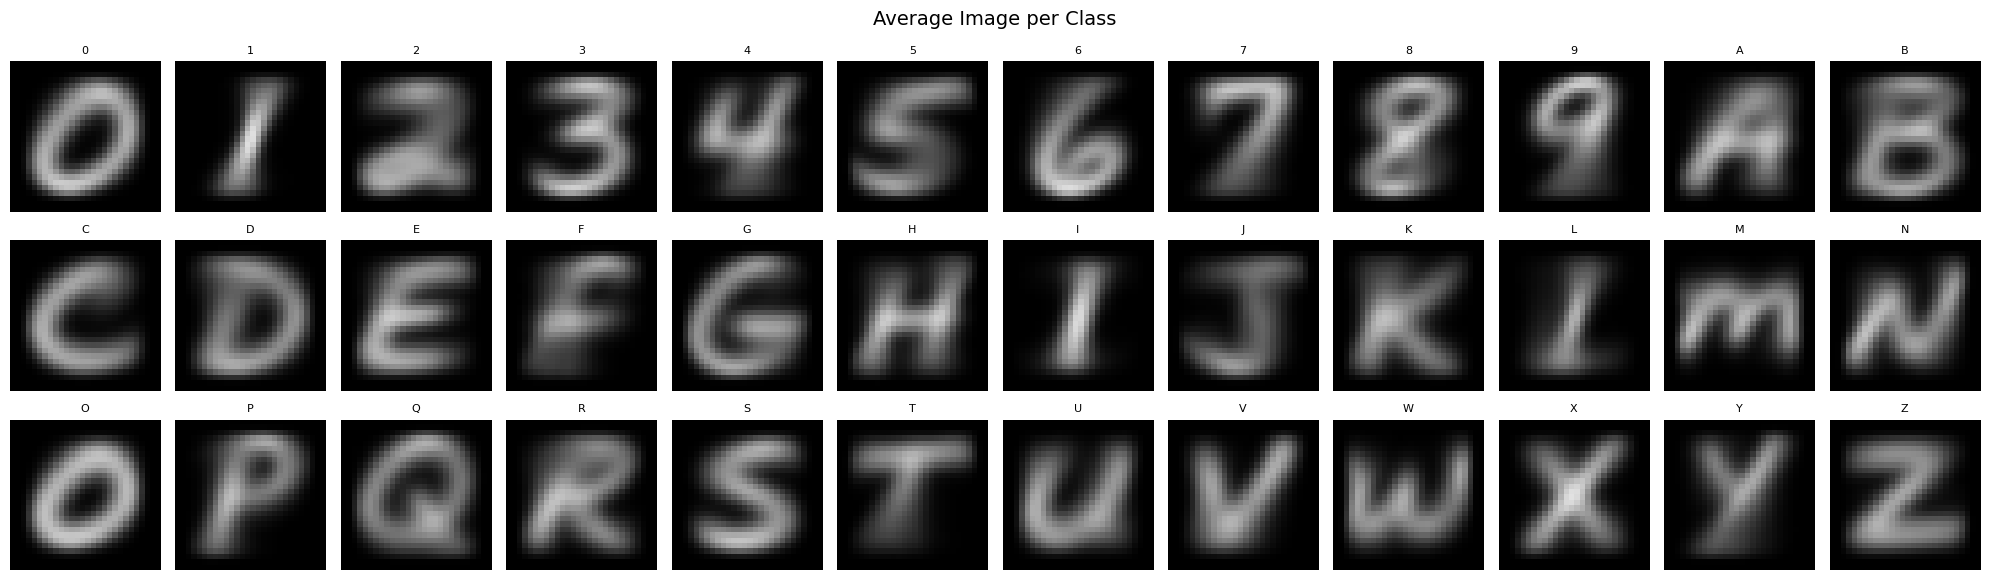

In [141]:
num_classes = len(full_dataset.classes)
class_sums = [torch.zeros(3, 28, 28) for _ in range(num_classes)]
class_counts = [0 for _ in range(num_classes)]
for img, label in full_dataset:
    class_sums[label] += img
    class_counts[label] += 1
class_averages = [class_sums[i] / class_counts[i] for i in range(num_classes)]

fig, axes = plt.subplots(3, 12, figsize=(20, 6))
for i, avg_img in enumerate(class_averages):
    ax = axes[i // 12, i % 12]
    img_np = avg_img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_dataset.classes[i], fontsize=8)
    ax.axis('off')
plt.suptitle("Average Image per Class", fontsize=14)
plt.tight_layout()
plt.show()

All classes have around 2800 samples so its balanced. I that case I considered to no handling in class imbalance.

Test Train Val Split

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import numpy as np
import random

all_indices = list(range(len(full_dataset)))
all_labels = [label for _, label in full_dataset]

train_idx, testval_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)
testval_labels = [all_labels[i] for i in testval_idx]
val_idx, test_idx = train_test_split(testval_idx, test_size=0.5, stratify=testval_labels, random_state=42)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)
mini_indices = random.sample(range(len(train_dataset)), 5000)
mini_train_dataset = Subset(train_dataset, mini_indices)
train_loader = DataLoader(mini_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 80640
Validation set size: 10080
Test set size: 10080


## CNN

In [143]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary  

class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Three convolutional layers: 32, 64, and 128 filters,
Max pooling and dropout for regularization,
Flattening followed by two dense layers (256 units and 36-class output),
ReLU activation throughout,
It was optimized for 28x28 grayscale character images.

Model Summary

In [144]:
model = BaseCNN(num_classes=36)
summary(model, input_size=(64, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN                                  [64, 36]                  --
├─Sequential: 1-1                        [64, 128, 14, 14]         --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          896
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 64, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 128, 14, 14]         73,856
│    └─ReLU: 2-7                         [64, 128, 14, 14]         --
│    └─Dropout: 2-8                      [64, 128, 14, 14]         --
├─Sequential: 1-2                        [64, 36]                  --
│    └─Flatten: 2-9                      [64, 25088]               --
│    └─Linear: 2-10                      [64, 256]                 6,422,784

Training

In [145]:
import copy
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, correct_preds = 0.0, 0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds.double() / len(train_loader.dataset)
        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc.item())
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct.double() / len(val_loader.dataset)
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc.item())
        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if scheduler:
            scheduler.step()
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

I trained the model for 3 epochs using 5,000 training samples for faster testing in my system, with batch size = 64.

In [146]:
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

First Optimizer: Adam, Dropout and Weight regularization (L2)

In [ ]:
optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5, gamma=0.5)
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion,
    optimizer_adam, scheduler=scheduler, num_epochs=3
)
torch.save(model.state_dict(), "cnn_best_adam.pt")
#Usage of optimizer was refers from Geeks for Geeks


Epoch 1/3


Training Epoch 1: 100%|██████████| 79/79 [00:08<00:00,  9.84it/s]


Train Loss: 2.2070, Acc: 0.3816
Val   Loss: 0.9754, Acc: 0.7080

Epoch 2/3


Training Epoch 2: 100%|██████████| 79/79 [00:07<00:00, 10.90it/s]


Train Loss: 1.0579, Acc: 0.6738
Val   Loss: 0.7049, Acc: 0.7701

Epoch 3/3


Training Epoch 3: 100%|██████████| 79/79 [00:07<00:00, 11.11it/s]


Train Loss: 0.7620, Acc: 0.7586
Val   Loss: 0.5588, Acc: 0.8148


Second Optimizer: SGD

In [148]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion,
    optimizer, scheduler=scheduler, num_epochs=3
)
torch.save(model.state_dict(), "cnn_best_SGD.pt")


Epoch 1/3


Training Epoch 1: 100%|██████████| 79/79 [00:06<00:00, 11.57it/s]


Train Loss: 0.7465, Acc: 0.7592
Val   Loss: 0.6029, Acc: 0.8161

Epoch 2/3


Training Epoch 2: 100%|██████████| 79/79 [00:07<00:00, 10.51it/s]


Train Loss: 0.5876, Acc: 0.8114
Val   Loss: 0.5379, Acc: 0.8273

Epoch 3/3


Training Epoch 3: 100%|██████████| 79/79 [00:07<00:00, 11.12it/s]


Train Loss: 0.4934, Acc: 0.8318
Val   Loss: 0.5204, Acc: 0.8335


Third Optimizer: AdamW

In [149]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion,
    optimizer, scheduler=scheduler, num_epochs=3
)
torch.save(model.state_dict(), "cnn_best_adamW.pt")


Epoch 1/3


Training Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training Epoch 1: 100%|██████████| 79/79 [00:07<00:00, 11.24it/s]


Train Loss: 0.5373, Acc: 0.8180
Val   Loss: 0.4996, Acc: 0.8354

Epoch 2/3


Training Epoch 2: 100%|██████████| 79/79 [00:06<00:00, 11.29it/s]


Train Loss: 0.4174, Acc: 0.8532
Val   Loss: 0.4748, Acc: 0.8437

Epoch 3/3


Training Epoch 3: 100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


Train Loss: 0.3627, Acc: 0.8694
Val   Loss: 0.4538, Acc: 0.8523


Evaluation

Test Accuracy for Adam: 81.66%


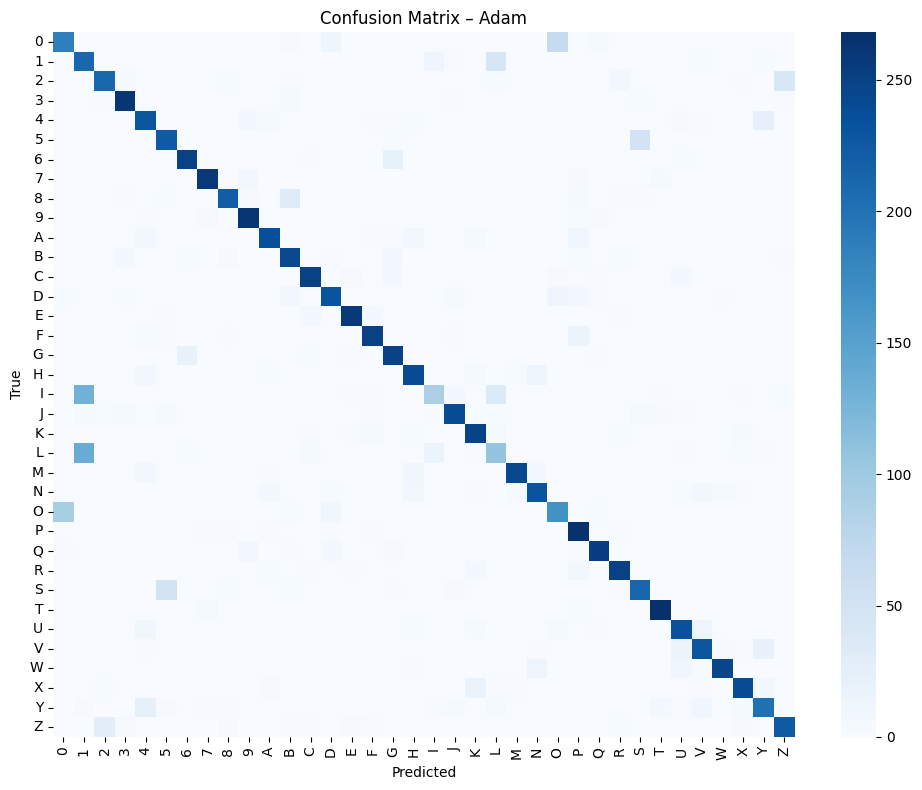


Classification Report – Adam
              precision    recall  f1-score   support

           0      0.645     0.668     0.656       280
           1      0.430     0.754     0.547       280
           2      0.821     0.754     0.786       280
           3      0.897     0.936     0.916       280
           4      0.749     0.821     0.784       280
           5      0.763     0.804     0.783       280
           6      0.896     0.896     0.896       280
           7      0.935     0.925     0.930       280
           8      0.899     0.793     0.843       280
           9      0.894     0.932     0.913       280
           A      0.891     0.843     0.866       280
           B      0.771     0.864     0.815       280
           C      0.913     0.896     0.905       280
           D      0.856     0.829     0.842       280
           E      0.931     0.921     0.926       280
           F      0.893     0.893     0.893       280
           G      0.814     0.893     0.852       2

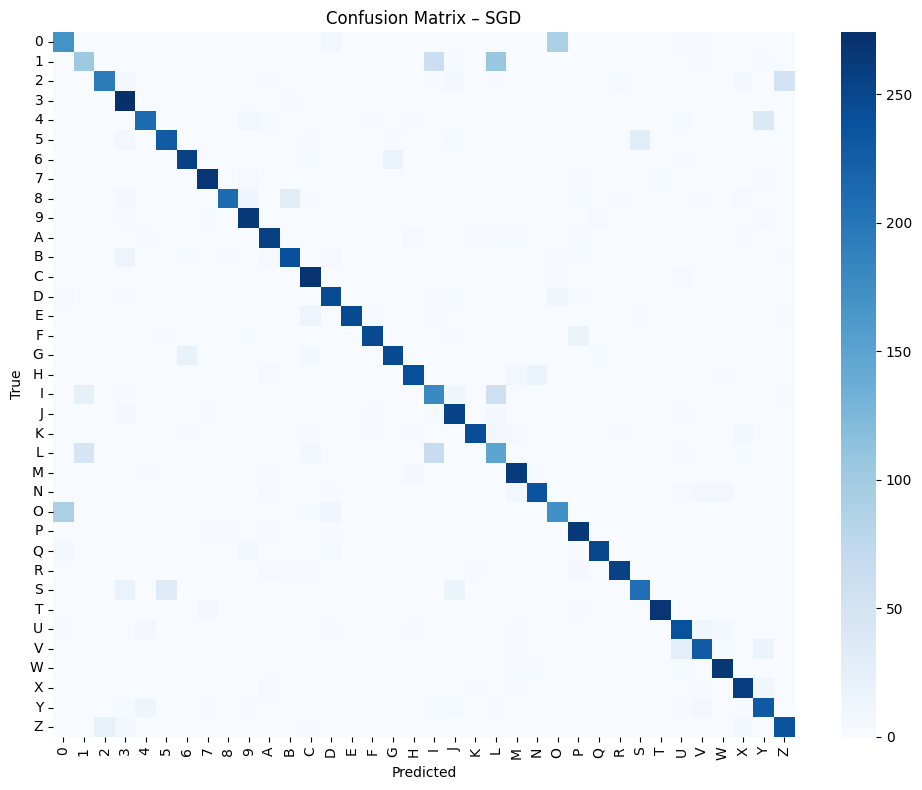


Classification Report – SGD
              precision    recall  f1-score   support

           0      0.605     0.607     0.606       280
           1      0.589     0.368     0.453       280
           2      0.886     0.693     0.778       280
           3      0.776     0.979     0.866       280
           4      0.858     0.757     0.805       280
           5      0.854     0.814     0.834       280
           6      0.889     0.914     0.901       280
           7      0.937     0.954     0.945       280
           8      0.964     0.757     0.848       280
           9      0.868     0.939     0.902       280
           A      0.862     0.918     0.889       280
           B      0.848     0.857     0.853       280
           C      0.851     0.961     0.903       280
           D      0.869     0.879     0.874       280
           E      0.996     0.882     0.936       280
           F      0.947     0.886     0.915       280
           G      0.908     0.882     0.895       28

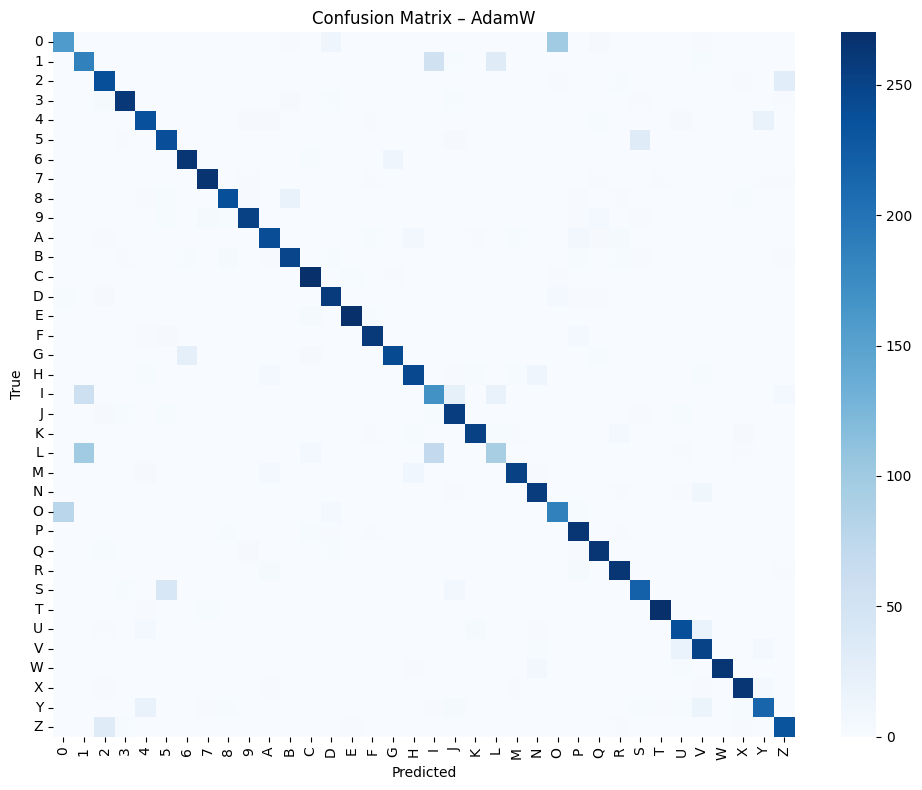


Classification Report – AdamW
              precision    recall  f1-score   support

           0      0.642     0.564     0.601       280
           1      0.536     0.664     0.593       280
           2      0.796     0.850     0.822       280
           3      0.932     0.932     0.932       280
           4      0.832     0.846     0.839       280
           5      0.805     0.854     0.828       280
           6      0.889     0.943     0.915       280
           7      0.953     0.946     0.950       280
           8      0.926     0.850     0.886       280
           9      0.951     0.900     0.925       280
           A      0.892     0.857     0.874       280
           B      0.892     0.886     0.889       280
           C      0.891     0.961     0.924       280
           D      0.881     0.921     0.901       280
           E      0.954     0.964     0.959       280
           F      0.922     0.929     0.925       280
           G      0.920     0.868     0.893       

In [150]:
def evaluate_model(model_path, label, num_classes=36):
    model = CNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = (y_true == y_pred).mean() * 100
    print(f"Test Accuracy for {label}: {accuracy:.2f}%")
    return np.array(y_true), np.array(y_pred)
def plot_confusion_and_report(y_true, y_pred, class_names, label):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix – {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print(f"\nClassification Report – {label}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

model_paths = {
    "Adam": "cnn_best_adam.pt",
    "SGD": "cnn_best_sgd.pt",
    "AdamW": "cnn_best_adamW.pt"
}
class_names = full_dataset.classes
for opt_name, path in model_paths.items():
    y_true, y_pred = evaluate_model(path, opt_name)
    plot_confusion_and_report(y_true, y_pred, class_names, opt_name)

AdamW emerged as the most balanced and accurate because of its ability to decouple weight decay from gradient updates, better regularization so more stable test accuracy.

## Misclassified images

In [151]:
def get_misclassified_samples(model_path, num_samples=8):
    model = CNN(num_classes=36).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, true in zip(images, preds, labels):
                if pred != true:
                    misclassified.append((img.cpu(), pred.cpu().item(), true.cpu().item()))
                if len(misclassified) >= num_samples:
                    return misclassified
    return misclassified

def plot_misclassified(misclassified, class_names):
    plt.figure(figsize=(15, 4))
    for i, (img, pred, true) in enumerate(misclassified):
        plt.subplot(1, len(misclassified), i + 1)
        plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}", fontsize=10)
        plt.axis("off")
    plt.suptitle("Sample Misclassified Images")
    plt.tight_layout()
    plt.show()


For Adam

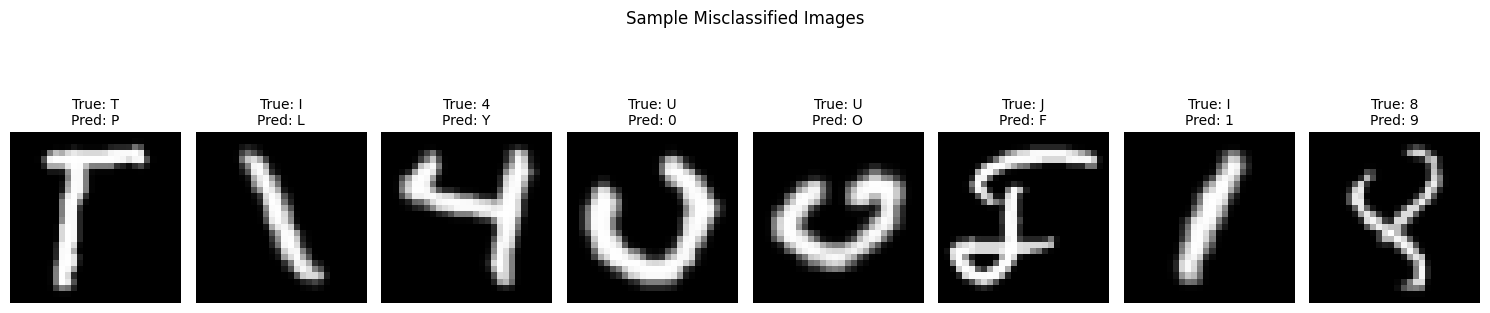

In [152]:
misclassified = get_misclassified_samples("cnn_best_adam.pt")
plot_misclassified(misclassified, full_dataset.classes)


For SGD

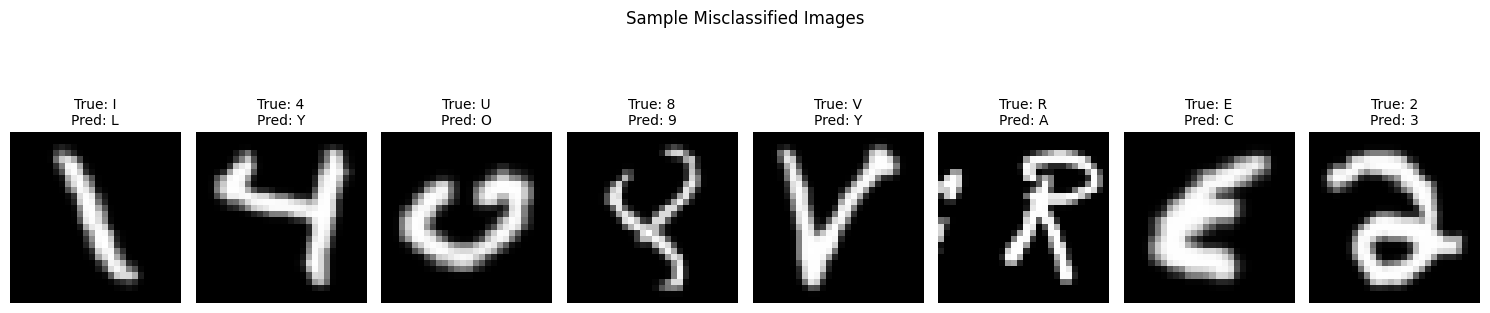

In [153]:
misclassified = get_misclassified_samples("cnn_best_SGD.pt")
plot_misclassified(misclassified, full_dataset.classes)

For AdamW

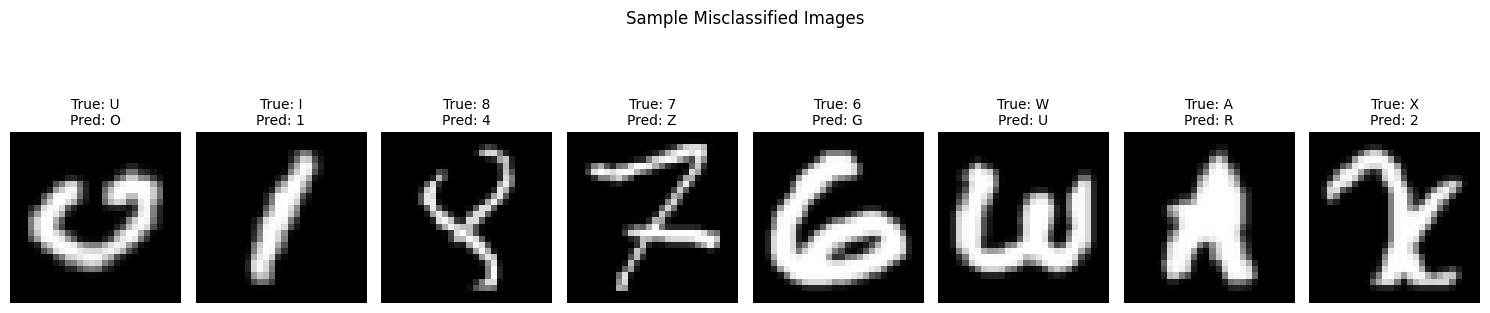

In [154]:
misclassified = get_misclassified_samples("cnn_best_adamW.pt")
plot_misclassified(misclassified, full_dataset.classes)

These errors mostly occur due to:Visual similarity, Ambiguous handwriting styles, Stroke thickness variations, Rotation or slant in characters